In [13]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import yaml
import os

In [14]:
# Move up to the parent directory and then into the 'utils' folder
os.chdir('../utils')

# Verify the new working directory
print("New working directory:", os.getcwd())

New working directory: C:\Users\Yifei Zhou\Documents\GitHub\RCCarRelated\utils


In [15]:
from camera_warp import warp_image_path, warp_image_undistorted
from camera_calib import undistort_image, undistort_image_path

# Load calibration data
with open('camera_calibration.yaml', 'r') as f:
    calibration_data = yaml.safe_load(f)

camera_matrix = np.array(calibration_data['camera_matrix'])
dist_coeffs = np.array(calibration_data['dist_coeff'])

camera_matrix, dist_coeffs

(array([[1.94866228e+03, 0.00000000e+00, 1.21919177e+03],
        [0.00000000e+00, 1.95291066e+03, 1.23802581e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-4.86357471e-01,  2.85510824e-01,  4.39241866e-04,
         -1.57533189e-03, -9.47115634e-02]]))

In [16]:
import os
# Expand tilde (~) to full user home directory
image_path = os.path.expanduser(r"~\OneDrive - McMaster University\AutoRC\2025-03-12\gt_p1_h0_d0.jpg")

test_undistorted, _ = undistort_image_path(image_path)

# Call the function
warped_img, M, Minv = warp_image_path(image_path)

In [17]:
# original_img = cv2.imread(image_path)
# cv2.imshow('Original Image', original_img)
# cv2.imshow('Undistorted Image', test_undistorted)
# cv2.imshow('Bird\'s Eye View', warped_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [18]:
# Color space transformation

def color_space_transform(image):
    # Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define lower and upper thresholds for white
    lower_white = np.array([0, 0, 180])   # Minimum white (high Value)
    upper_white = np.array([180, 50, 255]) # Maximum white (low Saturation)
    
    # Thresholding to extract white
    mask = cv2.inRange(hsv, lower_white, upper_white)
    
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    edges = cv2.Canny(mask, 50, 150)  # Adjust thresholds as needed
    
    return mask, edges

In [19]:
# Copy from https://github.com/laavanyebahl/Advance-Lane-Detection-and-Keeping-
# Modified using claude.ai to work with newer NumPy versions

def sliding_window_polyfit(image):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0]//2)
    quarter_point = int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    # FIXME!! NOT SUITABLE FOR OUR  CONDITION
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 60
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    display_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, display_data

def polyfit_using_prev_fit(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 60
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

In [20]:
masked, images = color_space_transform(warped_img)

In [21]:
left_fit, right_fit, left_lane_inds, right_lane_inds, display_data = sliding_window_polyfit(masked)

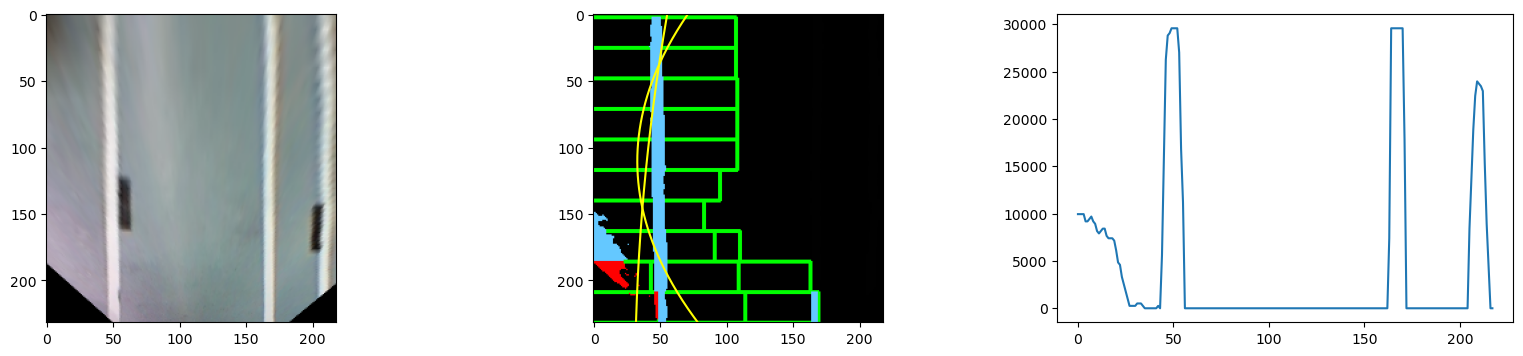

In [22]:
# Set up plot
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
axs = axs.ravel()

h = test_undistorted.shape[0]

left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

rectangles = display_data[0]
histogram = display_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((masked, masked, masked))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, masked.shape[0]-1, masked.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image

nonzero = masked.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]

axs[0].imshow(warped_img, cmap='gray')
axs[1].imshow(out_img, cmap='gray')
axs[1].plot(left_fitx, ploty, color='yellow')
axs[1].plot(right_fitx, ploty, color='yellow')

axs[2].plot(histogram)

In [23]:
# Open the video file
# OpenCV's cv2.VideoCapture() often struggles to open H.264-encoded videos directly, 
# especially when they are recorded using Picamera2. This happens because OpenCV does 
# not natively support H.264 due to licensing restrictions. Here’s how you can fix it:
# ffmpeg -i <input.h264> -c:v copy <output.mp4>
# or can use processed video: ~\OneDrive - McMaster University\AutoRC\2025-03-12\processed

# Expand tilde (~) to full user home directory
video_path = os.path.expanduser(r"~\Downloads\record\output.mp4")

# Check if the file exists
if os.path.exists(video_path):
    print("File exists:", video_path)
else:
    print("File does not exist:", video_path)
    
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Process video frame by frame
while True:
    # Read a frame from the video
    ret, frame = cap.read()
    
    # If no frame is read (end of video), break
    if not ret:
        print("End of video or error reading frame.")
        break

    img, _ = undistort_image(frame, camera_matrix, dist_coeffs)
    warped, _, _ = warp_image_undistorted(img)

    masked, edges = color_space_transform(warped)

    cv2.imshow('Video Frame', frame)
    cv2.imshow('Bird\'s Eye View', warped)
    cv2.imshow('Masked Image', masked)
    
    # Wait for 25ms and check for 'q' key to exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release the video capture object and close windows
cap.release()
cv2.destroyAllWindows()

File exists: C:\Users\Yifei Zhou\Downloads\record\output.mp4
End of video or error reading frame.


In [24]:
''' NOTE :
 xm_per_pixel = 0.36/117 ( 0.36 actual width of lane, 117 px on warped image)
 ym_per_pixel = 0.2 / 37 (0.2 m actual length of black line, 37 px length on warped image) 
'''
xm_per_pixel = 0.36 /117
ym_per_pixel = 0.2 / 37